In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, "../")

## Import

In [3]:
from collections import OrderedDict
import numpy
import pandas

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier

In [4]:
from utils import get_N_B_events, predict_by_estimator, bootstrap_calibrate_prob
from utils import get_events_number, get_events_statistics, result_table, compute_mistag, shrink_floats_xgb

## Reading initial data

In [8]:
import root_numpy
def read_samples(filename, filename_vtx, filename_splot):
    splot = pandas.read_csv(filename_splot, sep=' ', header=None).drop([8], axis=1)
    splot.columns = ['run', 'evTop', 'evBottom', 'Bmass', 'Nbkg_tot_sw', 'L_Nbkg_tot', 'Nsig_tot_sw', 'L_Nsig_tot']
    event_id_column = 'event_id'

    splot[event_id_column] = splot.run.apply(str) + '_' + (splot.evTop * 1e6 + splot.evBottom).apply(int).apply(str)
    index = numpy.unique(splot[event_id_column], return_index=True)[1]
    splot.index = numpy.arange(len(splot))
    splot = splot.ix[index, :]
    splot.index = splot[event_id_column]
    
    data = pandas.read_csv(filename, sep='\t')
    data = data.query('(Bmass < 5.4) & (Bmass > 5.16) & ((K_cut == 1) | (mu_cut == 1) | (e_cut == 1))')

    data_vertex = pandas.read_csv(filename_vtx, sep='\t')
    data_vertex = data_vertex.query('(Bmass < 5.4) & (Bmass > 5.16) & (v_cut == 1) & (vcharge > 0.2)')
    
    datasets = dict()
    for name, selection, data_temp in zip(['K', 'e', 'mu', 'vtx'], 
                                          ['K_cut == 1', 'e_cut == 1', 'mu_cut == 1', ""],
                                          [data] * 3 + [data_vertex]):
        if selection != "":
            data_temp = data_temp.query(selection)
        shrink_floats_xgb(data_temp)        
        if name == 'vtx':
            data_temp['label'] = (data_temp.signB.values * data_temp.signVtx.values < 0) * 1
        else:
            data_temp['label'] = (data_temp.signB.values * data_temp.signTrack.values < 0) * 1
        data_temp['event_id'] = data_temp.run.apply(str) + '_' + data_temp.event.apply(int).apply(str)
        data_temp['tagAnswer'] = data_temp.signB * (2 * data_temp.label - 1)
        data_temp.index = data_temp["event_id"]
        data_temp['N_sig_sw'] = splot.loc[data_temp.index, 'Nsig_tot_sw']
        datasets[name] = data_temp
    
    return datasets, sum(splot.Nsig_tot_sw.values)

In [9]:
def compute_efficiencies(datasets, N_B_events):
    result = dict()
    for key, data in datasets.items():
        N_B_passed = get_events_number(data)
        result[key] = (1. * N_B_passed / N_B_events, sqrt(N_B_passed) / N_B_events)
    return result

In [10]:
datasets, N_B_events = read_samples('../datasets/data/csv/WG/Bu_JPsiK/2012/Tracks.csv', 
                                    '../datasets/data/csv/WG/Bu_JPsiK/2012/Vertices.csv', 
                                    '../datasets/data/csv/WG/Bu_JPsiK/2012/sPlot_Bu_JPsiK.csv')

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [14]:
datasets_kstar, N_B_events_kstar = read_samples('../datasets/data/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', 
                                                '../datasets/data/csv/WG/Bd_JPsiKstar/2012/Vertices.csv', 
                                                '../datasets/data/csv/WG/Bd_JPsiKstar/2012/sPlot_Bd_JPsiKstar.csv')

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

## Calculate $\epsilon_{tag}$ for each datasets

In [15]:
eff = compute_efficiencies(datasets, N_B_events)
eff_kstar = compute_efficiencies(datasets_kstar, N_B_events_kstar)

In [16]:
print 'K+-'
print pandas.DataFrame(eff)
print 'K*'
print pandas.DataFrame(eff_kstar)

K+-
          K         e        mu       vtx
0  0.122194  0.021844  0.056905  0.120291
1  0.000418  0.000177  0.000285  0.000415
K*
          K         e        mu       vtx
0  0.126019  0.022164  0.058557  0.122501
1  0.000672  0.000282  0.000458  0.000663


## Features used in training

In [17]:
features_vtx = ['mult', 'nnkrec', 'log_ptB: log(ptB)', 'vflag', 'log_ipsmean: log(ipsmean)', 
                'log_ptmean: log(ptmean)', 'vcharge', 
                'log_svm: log(svm)', 'log_svp: log(svp)', 'BDphiDir', 'log_svtau: log(svtau)', 'docamax']

features_ele = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'log_eOverP: log(EOverP)', 
                'ghostProb', 'log_IPPU: log(IPPU)']
features_muon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'PIDNNm', 'ghostProb', 'log_IPPU: log(IPPU)']
features_kaon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                 'nnkrec','log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'log_IPPU: log(IPPU)']
                                    
features = {'e': features_ele, 'mu': features_muon,
            'K': features_kaon, 'vtx': features_vtx}

In [18]:
estimators = OrderedDict()

### XGBoost

In [19]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base_ele = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=12, 
                                 n_estimators=200, subsample=0.3, max_depth=5) 

xgb_base_other = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=12, 
                                   n_estimators=500, subsample=0.3, max_depth=3) 

for key, data in datasets.items():
    if 'e' in key:
        xgb_base = xgb_base_ele
    else:
        xgb_base = xgb_base_other
        
    estimators[key + '_xgboost'] = FoldingClassifier(xgb_base, n_folds=2, random_state=11,
                                                     features=features[key])
    estimators[key + '_xgboost'].fit(data, data['label'], data['N_sig_sw'])

### TMVA

In [20]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', TestRate=5,
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N:Silent', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for key, data in datasets.items():
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=11,
                                                  features=features[key])
    estimators[key + '_tmva'].fit(data, data['label'], data['N_sig_sw'])

Error in <TDecompLU::InvertLU>: matrix is singular, 20 diag elements < tolerance of 2.2204e-16
--- REP_Estimator            : [>>>>>>>>>>>>>>>>>>>>>>>] (99%, time left: 0 sec) 
Error in <TDecompLU::InvertLU>: matrix is singular, 13 diag elements < tolerance of 2.2204e-16
--- REP_Estimator            : [>>>>>>>>>>>>>>>>>>>>>>>] (99%, time left: 0 sec) 
Error in <TDecompLU::InvertLU>: matrix is singular, 1 diag elements < tolerance of 2.2204e-16
--- REP_Estimator            : [>>>>>>>>>>>>>>>>>>>>>>>] (99%, time left: 0 sec) 
Error in <TDecompLU::InvertLU>: matrix is singular, 5 diag elements < tolerance of 2.2204e-16
--- REP_Estimator            : [>>>>>>>>>>>>>>>>>>>>>>>] (99%, time left: 0 sec) 
Error in <TDecompLU::InvertLU>: matrix is singular, 24 diag elements < tolerance of 2.2204e-16
--- REP_Estimator            : [>>>>>>>>>>>>>>>>>>>>>>>] (99%, time left: 0 sec) 
Error in <TDecompLU::InvertLU>: matrix is singular, 17 diag elements < tolerance of 2.2204e-16
Error in <TDecompLU::D

In [ ]:
import cPickle
with open('../models/old-tagging-WG.pkl', 'r') as f:
    estimators = cPickle.load(f)

In [21]:
import cPickle
with open('../models/old-tagging-WG.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [22]:
estimators.keys()

['mu_xgboost',
 'vtx_xgboost',
 'K_xgboost',
 'e_xgboost',
 'mu_tmva',
 'vtx_tmva',
 'K_tmva',
 'e_tmva']

In [24]:
for key in datasets.keys():
    for suffix in ['_xgboost', '_tmva']:
        name = key + suffix
        probs = estimators[name].predict_proba(datasets[key])[:, 1]        
        print name, 'AUC:', roc_auc_score(datasets[key]['label'].values, 
                                          probs, sample_weight=datasets[key]['N_sig_sw'].values)

KFold prediction using folds column
 mu_xgboost AUC: 0.615283001614
KFold prediction using folds column
mu_tmva AUC: 0.608026710222
KFold prediction using folds column
vtx_xgboost AUC: 0.569979331691
KFold prediction using folds column
vtx_tmva AUC: 0.563388029178
KFold prediction using folds column
K_xgboost AUC: 0.561920935671
KFold prediction using folds column
K_tmva AUC: 0.552546600027
KFold prediction using folds column
e_xgboost AUC: 0.591664243696
KFold prediction using folds column
e_tmva AUC: 0.578115788624


--------

## Calculate quality for each tagger (ele, muon, kaon, vtx)

using isotonic final calibration with bootstrap

In [25]:
from utils import predict_by_estimator, calibrate_probs, run_taggers_combination

def combine(estimators, datasets, keys, N_B_events, logistic=False,
            return_calibrations=False, logistic_combined=True, model_name=None, with_roc=False):
    """
    :param suffix: suffix used for taggers
    :param model_name: name for model after combining classifiers
    """
    data_with_predictions = {}
    calibrators_tracks = dict()
    
    # computing calibrated predictions of each tagger
    for key in keys:
        data, probs = predict_by_estimator(estimators[key], [datasets[key]])
        probs_calibrated, calibrators_tracks[key] = \
            calibrate_probs(data.label.values, data.N_sig_sw.values, probs, logistic=logistic)
            
        ids = numpy.array(data['event_id'])
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                       'tag_{}'.format(key): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids)
        
    calibrator_B, table, roc = run_taggers_combination(data_with_predictions, keys, N_B_events, 
                                                       model_name=','.join(keys) if model_name is None else model_name, 
                                                       logistic_combined=logistic_combined)
    if return_calibrations and with_roc:
        return table, calibrators_tracks, calibrator_B, roc
    elif return_calibrations and not with_roc:
        return table, calibrators_tracks, calibrator_B
    elif with_roc:
        return table, roc
    else:
        return table

### TMVA

In [26]:
test_estimators_tmva = dict((key, estimators[key + '_tmva']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.7416973084 AUC with untag: 0.521860151401


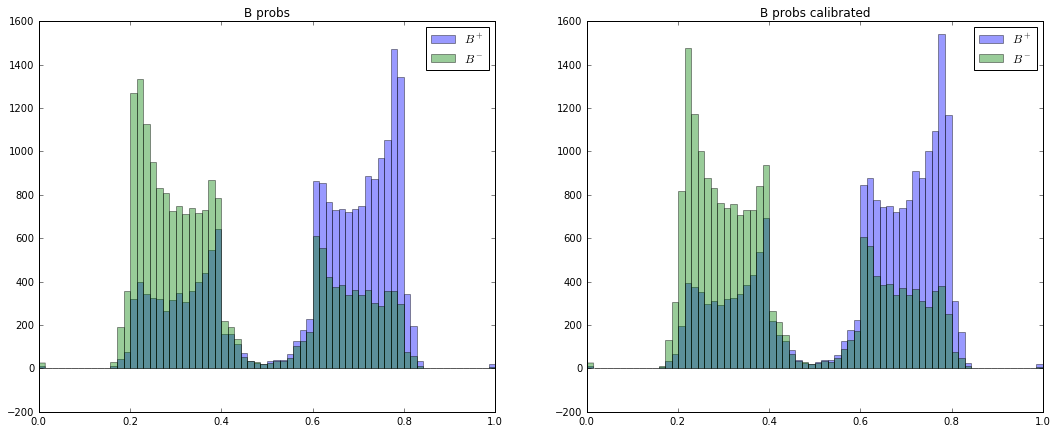

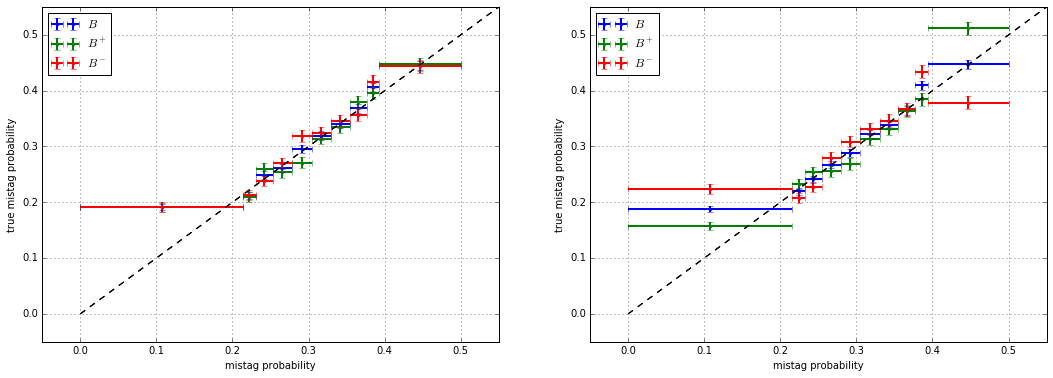

Efficiency, not calibrated 1.0263212746
Average AUC 0.741542188206 0.000250223220661
KFold prediction using folds column
AUC for tagged: 0.650171603401 AUC with untag: 0.52780035775


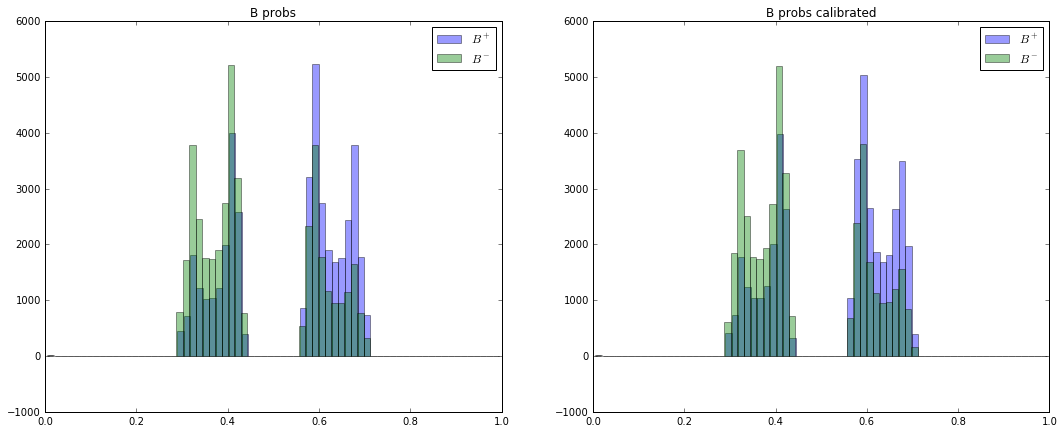

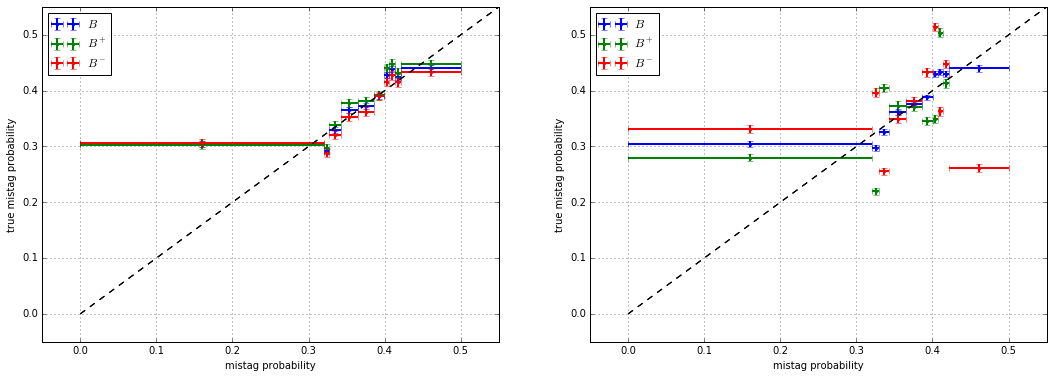

Efficiency, not calibrated 0.835986404254
Average AUC 0.650057803361 9.29232488833e-05
KFold prediction using folds column
AUC for tagged: 0.626055292633 AUC with untag: 0.524180897224


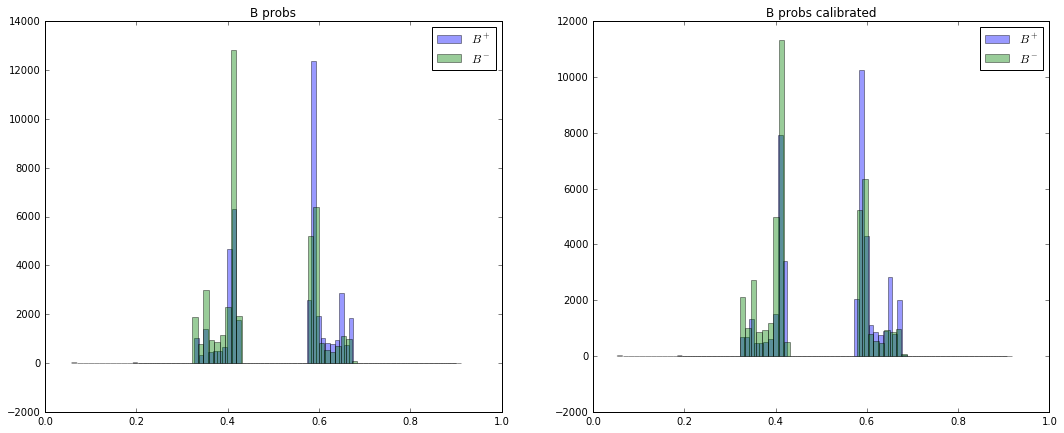

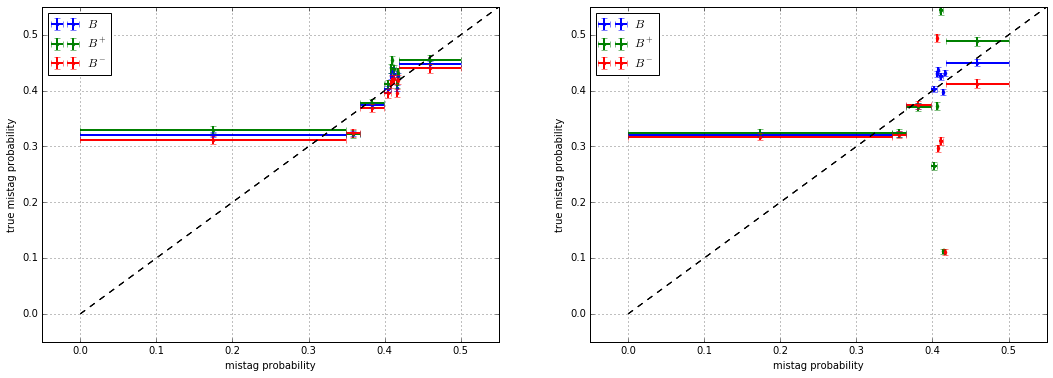

Efficiency, not calibrated 0.581916641443
Average AUC 0.625524953452 0.000308566445509
KFold prediction using folds column
AUC for tagged: 0.715732592941 AUC with untag: 0.507901650544


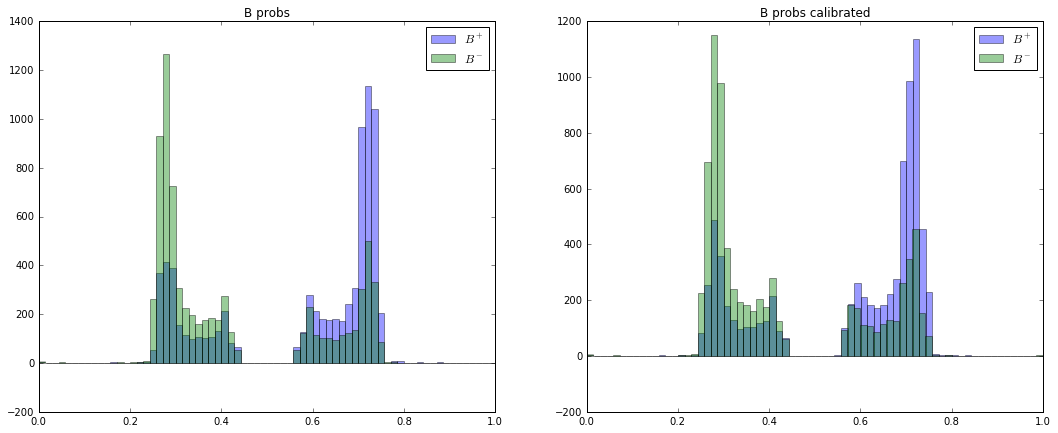

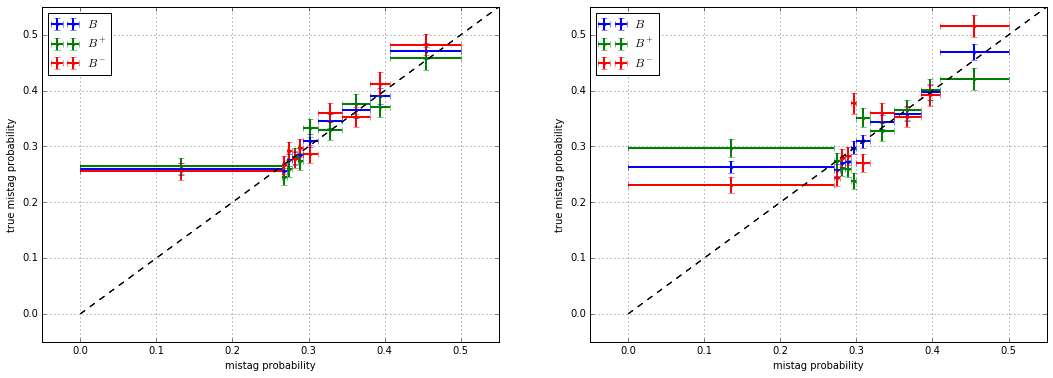

Efficiency, not calibrated 0.333336707902
Average AUC 0.715100516692 0.000625151361574


In [27]:
figsize(18, 7)

results_separate_tmva = []
for key in datasets.keys(): 
    x = combine(test_estimators_tmva, datasets, [key], N_B_events, logistic=True)
    results_separate_tmva.append(x)

In [28]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.690475,0.028539,0.175370,0.001680,0.997941,0.010792,52.186015,0
0,vtx,12.029093,0.041493,0.068547,0.000163,0.824553,0.003454,52.780036,0
0,K,12.219391,0.041820,0.049566,0.000107,0.605667,0.002449,52.418090,0
0,e,2.184355,0.017682,0.145882,0.002225,0.318658,0.005503,50.790165,0


### XGBoost

In [29]:
test_estimators = dict((key, estimators[key + '_xgboost']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.74425683896 AUC with untag: 0.521863381728


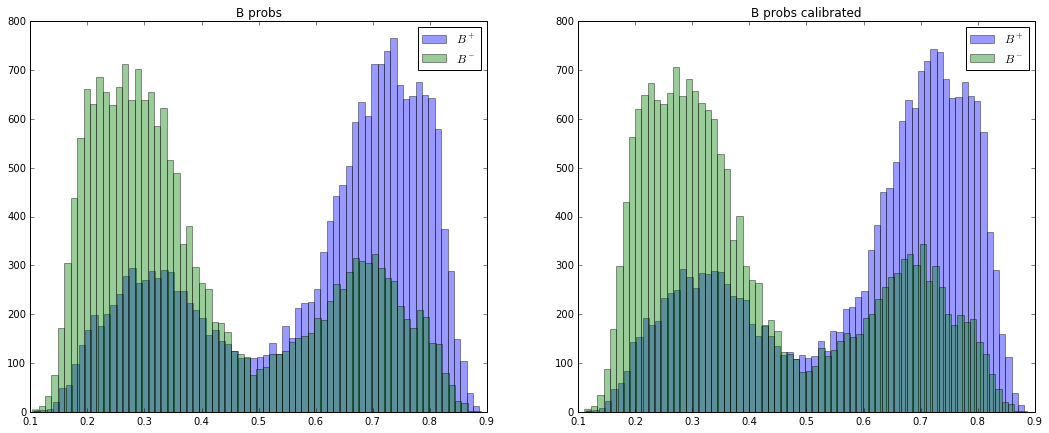

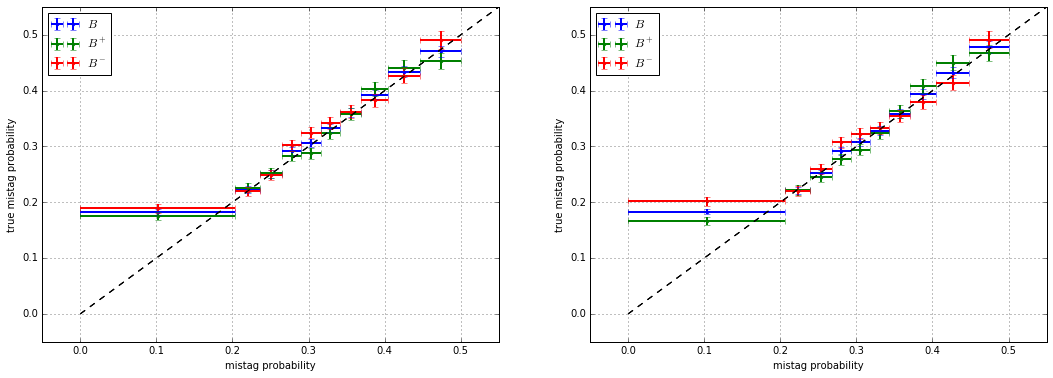

Efficiency, not calibrated 1.07844271226
Average AUC 0.744158113838 0.000175101443054
KFold prediction using folds column
AUC for tagged: 0.654010022981 AUC with untag: 0.527754324282


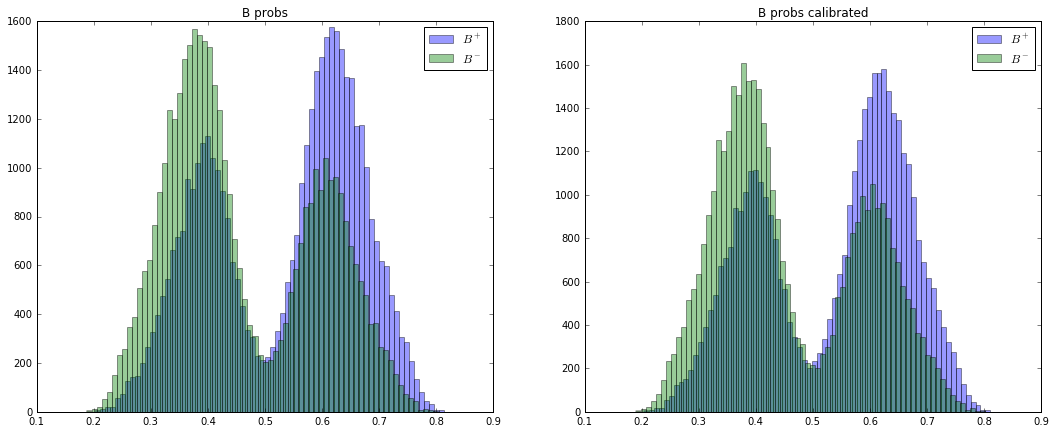

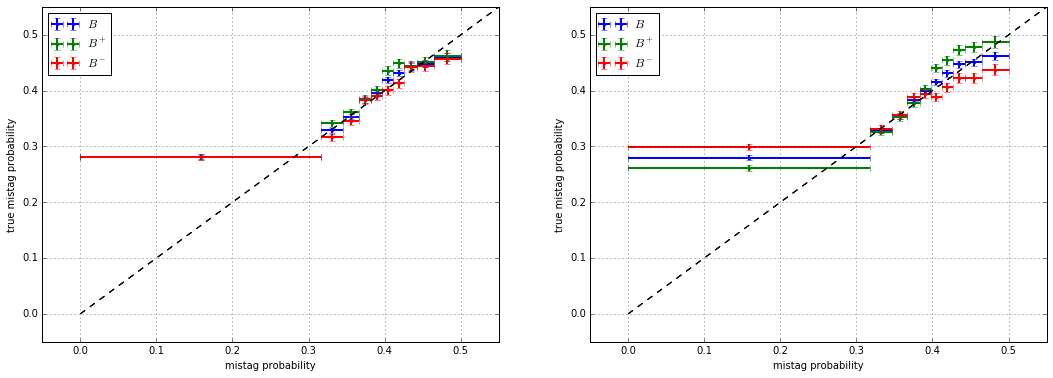

Efficiency, not calibrated 0.884643924047
Average AUC 0.653972611028 4.32515569323e-05
KFold prediction using folds column
AUC for tagged: 0.633571003678 AUC with untag: 0.524246347351


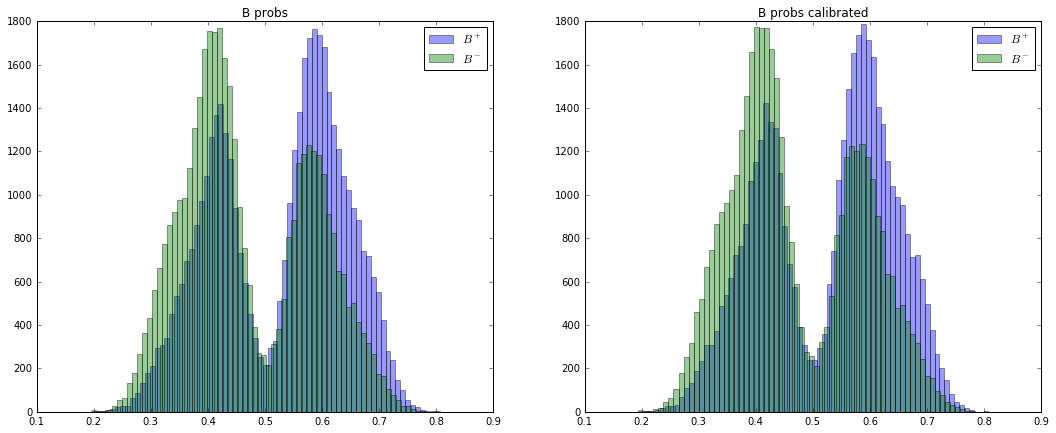

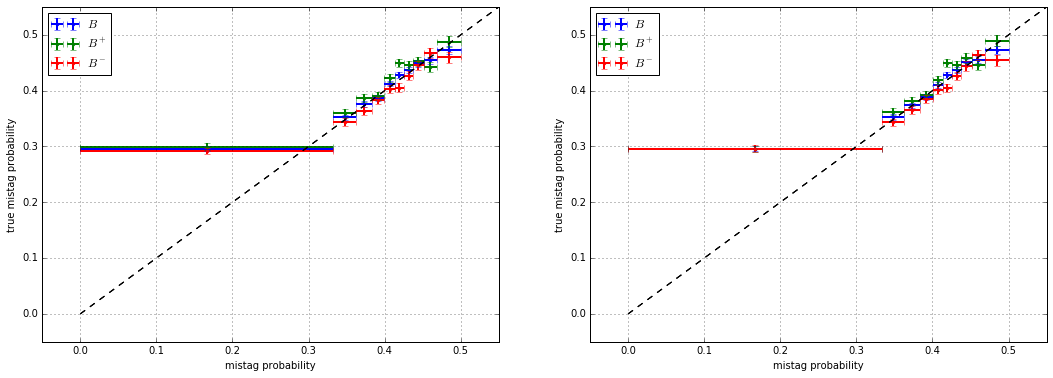

Efficiency, not calibrated 0.664128770247
Average AUC 0.633531834197 4.20776749705e-05
KFold prediction using folds column
AUC for tagged: 0.721995933221 AUC with untag: 0.507912832433


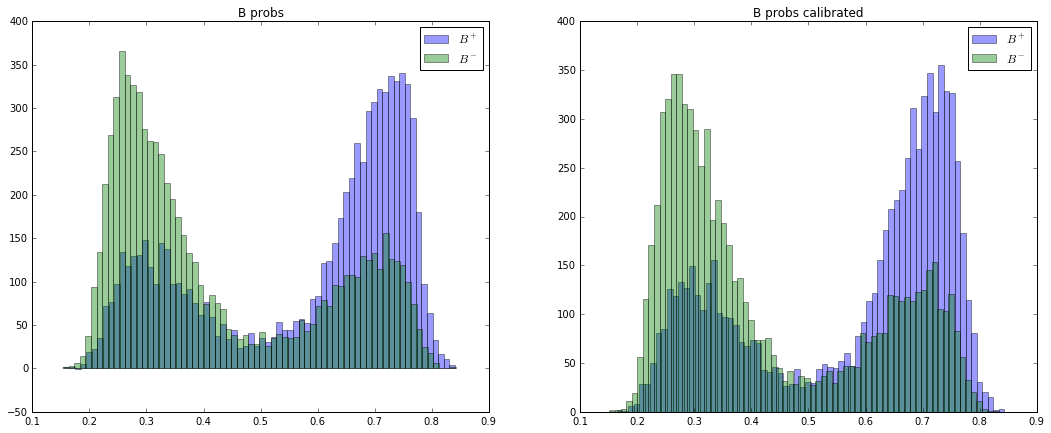

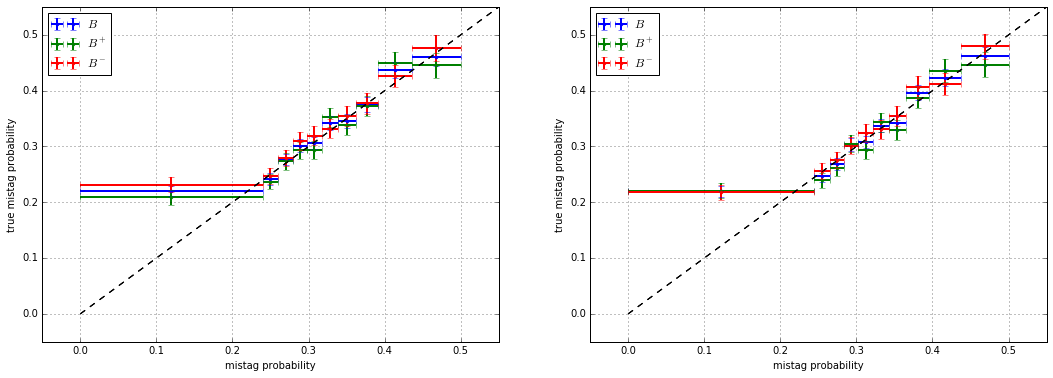

Efficiency, not calibrated 0.343143744216
Average AUC 0.72167637548 0.000340271431752


In [30]:
figsize(18, 7)

calibrators_B = dict()
calibrator_tracks = dict()

results_separate = []
for key in datasets.keys(): 
    x, calibrator_tracks[key], calibrators_B[key] = combine(test_estimators, datasets, [key], N_B_events,
                                                            logistic=True, return_calibrations=True)
    results_separate.append(x)

In [31]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.690475,0.028539,0.182471,0.001749,1.038347,0.011232,52.186338,0
0,vtx,12.029093,0.041493,0.072225,0.000161,0.868800,0.003570,52.775432,0
0,K,12.219391,0.041820,0.054004,0.000128,0.659901,0.002749,52.424635,0
0,e,2.184355,0.017682,0.152406,0.002252,0.332910,0.005608,50.791283,0


# Combination of all taggers

### TMVA

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.668651711696 AUC with untag: 0.55961217291


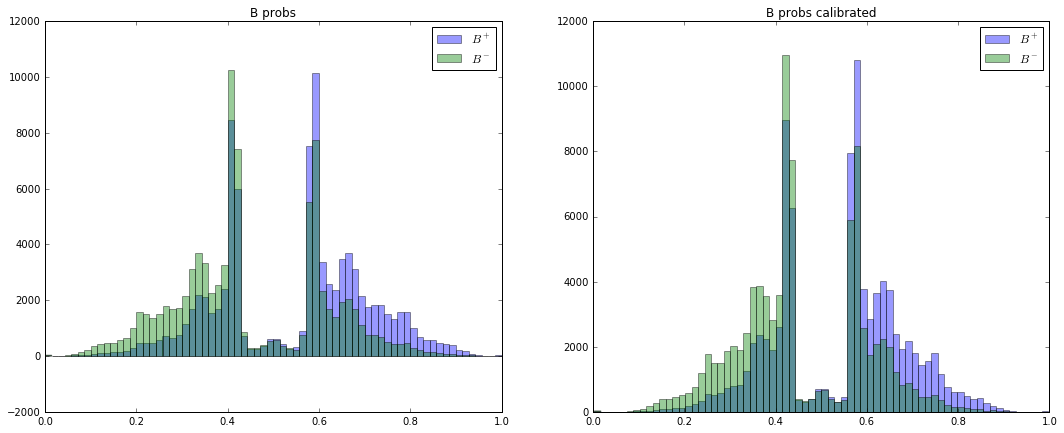

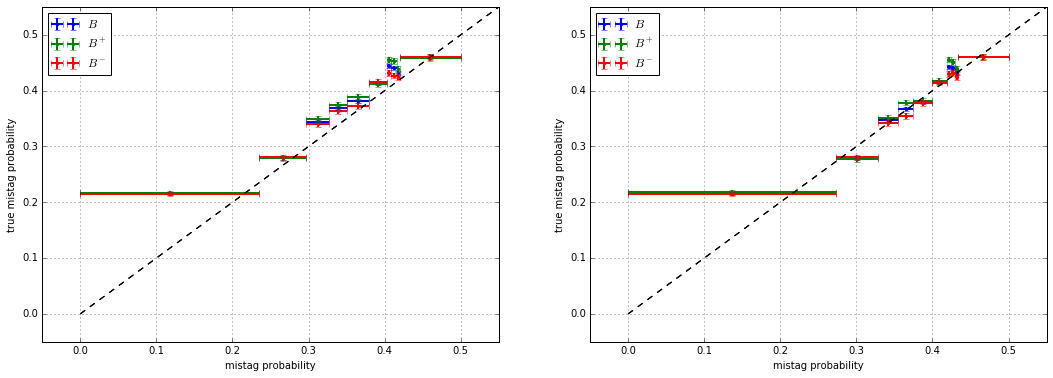

Efficiency, not calibrated 3.03939731544
Average AUC 0.668614651313 4.18397208346e-05


In [32]:
figsize(18, 7)

results_separate_tmva.append(combine(test_estimators_tmva, datasets, ['K', 'e', 'mu', 'vtx'], 
                                     N_B_events, logistic=True,
                                     model_name='tmva combination'))

### XGBoost

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.672312612002 AUC with untag: 0.560125736416


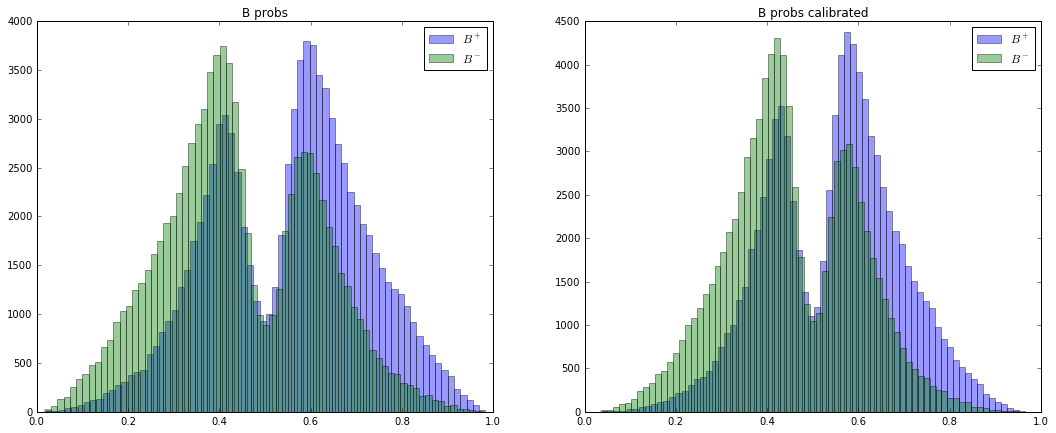

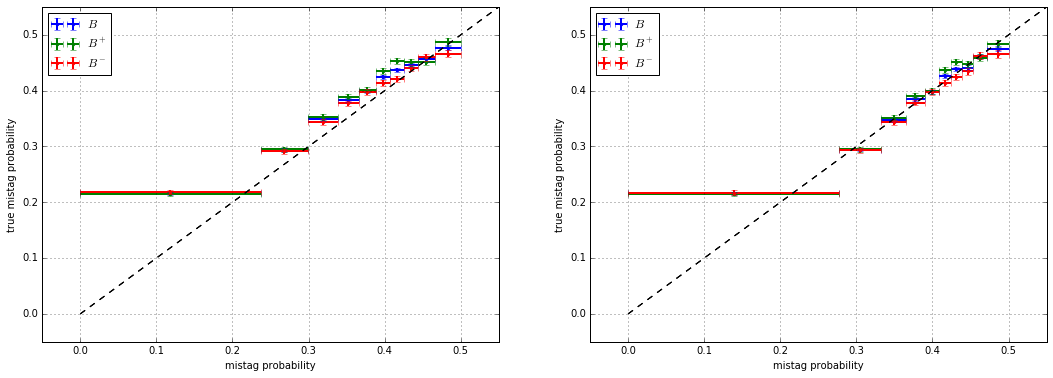

Efficiency, not calibrated 3.2172403392
Average AUC 0.672300211241 1.67090703662e-05


In [33]:
figsize(18, 7)

x, calibrator_tracks_comb, calibrator_B_comb, roc_curve_old = combine(test_estimators, datasets, 
                                                                      ['K', 'e', 'mu', 'vtx'], N_B_events,
                                                                      logistic=True, return_calibrations=True,
                                                                      model_name='xgboost combination', with_roc=True)
results_separate.append(x)

In [34]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.690475,0.028539,0.182471,0.001749,1.038347,0.011232,52.186338,0
0,vtx,12.029093,0.041493,0.072225,0.000161,0.868800,0.003570,52.775432,0
0,K,12.219391,0.041820,0.054004,0.000128,0.659901,0.002749,52.424635,0
0,e,2.184355,0.017682,0.152406,0.002252,0.332910,0.005608,50.791283,0
0,xgboost combination,25.821490,0.060793,0.090640,0.000256,2.340461,0.008611,56.012574,0


## Test combination of taggers on K*

In [45]:
from utils import prepare_B_data
def prepare_for_epm(estimators, datasets, keys, calibrator_tracks, calibrator_B, N_B_events):
    data_with_predictions = dict()
    for key in keys:
        probs = estimators[key].predict_proba(datasets[key])[:, 1]
        probs_calibrated = calibrator_tracks[key].predict_proba(probs)
    
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                      'tag_{}'.format(key): datasets[key].tagAnswer.values,
                                                      'weight': datasets[key].N_sig_sw.values,
                                                      'signB': datasets[key].signB.values,
                                                      'mass': datasets[key].Bmass.values,
                                                      'time': datasets[key]['time'].values}, 
                                                      index=numpy.array(datasets[key]['event_id']))
        
    tags, Bprobs, Bweights, Bsign, Bmass, Btime = prepare_B_data(data_with_predictions, keys)
    Bprob_calibrated = calibrator_B.predict_proba(Bprobs)
    
    print 'eff tag: ', 1. * sum(Bweights) / N_B_events
    print "D2:", numpy.average((1 - 2*Bprob_calibrated)**2, weights=Bweights)
    print 'eff:', 1. * sum(Bweights) / N_B_events * numpy.average((1 - 2*Bprob_calibrated)**2, weights=Bweights)
    
    
    mistag = numpy.minimum(Bprob_calibrated, 1 - Bprob_calibrated)
    tag = numpy.ones(len(Bprob_calibrated))
    tag[Bprob_calibrated < 0.5] = -1

    prepared_data = pandas.DataFrame({'tag': numpy.array(tag, dtype='int32'),
                                      'mistag': mistag,
                                      'flavour': numpy.array(Bsign, dtype='int32'),
                                      'decay_time': Btime,
                                      'Bmass': Bmass,
                                      'resolution': [50*1e-3] * len(Bmass),
                                      'probs': Bprob_calibrated,
                                      'weight': Bweights
                                     })
    return prepared_data

In [46]:
prepared_kstar = prepare_for_epm(test_estimators, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                 calibrator_tracks_comb, calibrator_B_comb, N_B_events_kstar)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
eff tag:  0.263473947465
D2: 0.0951548213464
eff: 0.0250708164005


In [47]:
root_numpy.array2root(prepared_kstar.to_records(index=False), "../for_epm/kstar_old.root", 
                      mode='recreate')

# Final results

### TMVA

In [48]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.690475,0.028539,0.175370,0.001680,0.997941,0.010792,52.186015,0
0,vtx,12.029093,0.041493,0.068547,0.000163,0.824553,0.003454,52.780036,0
0,K,12.219391,0.041820,0.049566,0.000107,0.605667,0.002449,52.418090,0
0,e,2.184355,0.017682,0.145882,0.002225,0.318658,0.005503,50.790165,0
0,tmva combination,25.821490,0.060793,0.086792,0.000241,2.241093,0.008167,55.961217,0


### XGBoost

In [49]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.690475,0.028539,0.182471,0.001749,1.038347,0.011232,52.186338,0
0,vtx,12.029093,0.041493,0.072225,0.000161,0.868800,0.003570,52.775432,0
0,K,12.219391,0.041820,0.054004,0.000128,0.659901,0.002749,52.424635,0
0,e,2.184355,0.017682,0.152406,0.002252,0.332910,0.005608,50.791283,0
0,xgboost combination,25.821490,0.060793,0.090640,0.000256,2.340461,0.008611,56.012574,0


In [50]:
pandas.concat(results_separate_tmva + results_separate).to_csv(
    '../img/old-tagging-WG.csv', header=True, index=False)

In [51]:
import cPickle
with open('../models/old-rocs-WG', 'w') as f:
    cPickle.dump(roc_curve_old, f)